本文主要探索如何使用深度学习框架 MXNet 或 TensorFlow 实现**线性回归**模型？并且以 Kaggle 上数据集 [USA_Housing](https://www.kaggle.com/vedavyasv/usa-housing) 做线性回归任务来预测房价。

回归任务，scikit-learn 亦可以实现，具体操作可以查看 [线性回归模型的原理与 scikit-learn 实现](https://www.jianshu.com/p/a65c3965e290)。

## 载入数据

In [28]:
import pandas as pd
import numpy as np

name = '../dataset/USA_Housing.csv'
dataset = pd.read_csv(name)

train = dataset.iloc[:3000,:]
test = dataset.iloc[3000:,:]

print(train.shape)
print(test.shape)

(3000, 7)
(2000, 7)


查看有无缺失值：

In [8]:
print(np.unique(train.isnull().any()))
print(np.unique(test.isnull().any()))

[False]
[False]


In [9]:
dataset.columns  # 查看所有特征名称

Index(['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
       'Avg. Area Number of Bedrooms', 'Area Population', 'Price', 'Address'],
      dtype='object')

我们不考虑 `'Address'` 特征。通过特征 `'Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms', 'Avg. Area Number of Bedrooms', 'Area Population'` 来预测 `'Price'`。

In [10]:
features_column = [
    name for name in dataset.columns if name not in ['Price', 'Address']
]
label_column = ['Price']

x_train = train[features_column]
y_train = train[label_column]
x_test = test[features_column]
y_test = test[label_column]

为了更好的理解线性回归的原理，我们先动手自己实现：

## 数据标准化

线性回归模型就是单层神经网络，在神经网络的训练中，需要将数据进行标准化处理，使得数据的尺度统一。

In [11]:
from sklearn.preprocessing import scale

标准化处理：

In [12]:
x_train_s = scale(x_train)
x_test_s = scale(x_test)

为了更红的管理数据集我们先定义一个针对数据集处理的统一 API：`Loader`。为了和不同的深度学习框架进行接洽，`Loader` 被限制为输出 Numpy 数组。

In [13]:
class Loader(dict):
    """
    方法
    ========
    L 为该类的实例
    len(L)::返回样本数目
    iter(L)::即为数据迭代器

    Return
    ========
    可迭代对象（numpy 对象）
    """

    def __init__(self, batch_size, X, Y=None, shuffle=True, name=None):
        '''
        X, Y 均为类 numpy, 可以是 HDF5
        '''
        if name is not None:
            self.name = name
        self.X = np.asanyarray(X[:])
        if Y is None:
            # print('不存在标签！')
            self.Y = None
        else:
            self.Y = np.asanyarray(Y[:])
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.nrows = self.X.shape[0]

    def __iter__(self):
        idx = np.arange(self.nrows)

        if self.shuffle:
            np.random.shuffle(idx)

        for k in range(0, self.nrows, self.batch_size):
            K = idx[k:min(k + self.batch_size, self.nrows)]
            if self.Y is None:
                yield np.take(self.X, K, 0)
            else:
                yield np.take(self.X, K, 0), np.take(self.Y, K, 0)
                
    def __len__(self):
        return self.nrows

由于预测的值很大，为了加快训练速度，我们将其转换为：

In [14]:
batch_size = 64
trainset = Loader(batch_size, x_train_s, y_train)

## MXNet 训练

In [15]:
from mxnet import nd, autograd
from mxnet.gluon import nn

In [11]:
def linreg(X, w, b):
    '''
    线性回归模型
    '''
    return nd.dot(X, w) + b


def squared_loss(y_hat, y):
    '''
    l_2 损失
    '''
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


def sgd(params, lr, batch_size):
    for param in params:
        param[:] -= lr * param.grad / batch_size

In [12]:
%%time
n_features = x_train.shape[1]

# 参数初始化
w = nd.random_normal(shape=(n_features, 1))
b = nd.zeros([1])
params = [w, b]

for param in params:
    param.attach_grad()

# 超参数设定
lr = .45
epochs = 10
net = linreg
loss = squared_loss
test_l = []
for epoch in range(epochs):
    train_l = 0
    for x, y in trainset:
        x = nd.array(x, dtype=np.float32)
        y = nd.array(y, dtype=np.float32)
        with autograd.record():
            out = net(x, w, b)
            L = loss(out, y)
        L.backward()
        sgd([w, b], lr, batch_size)
        train_l += L.sum().asscalar()
    test_l.append(loss(net(nd.array(x_test_s), w, b),
                       nd.array(y_test)).mean().asscalar())
    print(f'Epoch {epoch}, train loss {train_l/len(trainset)}')

Epoch 0, train loss 31618141962.24
Epoch 1, train loss 5227899371.52
Epoch 2, train loss 5213236106.581333
Epoch 3, train loss 5218263345.834666
Epoch 4, train loss 5239229207.893333
Epoch 5, train loss 5258389263.701333
Epoch 6, train loss 5229723735.381333
Epoch 7, train loss 5193707612.842667
Epoch 8, train loss 5248076775.424
Epoch 9, train loss 5249794779.818666
Wall time: 617 ms


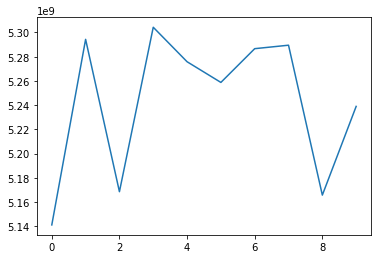

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(test_l)
plt.show()

In [14]:
from sklearn.metrics import r2_score
out = net(nd.array(x_test_s), w, b).asnumpy()

r2_score(y_test, out)

0.9160266711438344

## TensorFlow 训练

In [15]:
import tensorflow as tf

In [16]:
def linreg(X, w, b):
    '''
    线性回归模型
    '''
    return tf.matmul(X, w) + b

In [17]:
%%time
n_features = x_train.shape[1]
lr = .45

# 参数初始化
w = tf.Variable(tf.random_normal(shape=(n_features, 1)))
b = tf.Variable(tf.zeros([1]))

x = tf.placeholder(tf.float32, [None, n_features])
y = tf.placeholder(tf.float32, [None, 1])

loss = (y - linreg(x, w, b))**2 / 2
train_op = tf.train.GradientDescentOptimizer(lr).minimize(loss)
test_out = linreg(tf.constant(x_test_s, tf.float32), w, b)
init = tf.global_variables_initializer()

epochs = 10
with tf.Session() as sess:
    for epoch in range(epochs):
        train_l = 0
        for data, labels in trainset:
            data = data.astype(np.float32)
            labels = labels.astype(np.float32)
            sess.run(init)
            train_, _ = sess.run(
                [loss, train_op], feed_dict={
                    x: data,
                    y: labels
                })
            train_l += train_.sum()
        print(f'Epoch {epoch}, train loss {train_l/ len(trainset)}')
    out = sess.run(test_out)

Epoch 0, train loss 825207346429.952
Epoch 1, train loss 825207220600.832
Epoch 2, train loss 825207307283.1146
Epoch 3, train loss 825207276524.8854
Epoch 4, train loss 825207298894.5067
Epoch 5, train loss 825207349226.1547
Epoch 6, train loss 825207335245.1414
Epoch 7, train loss 825207173065.3867
Epoch 8, train loss 825207325458.432
Epoch 9, train loss 825207249960.96
Wall time: 4.17 s


TensorFlow 与 MXNet 相比，慢了许多。

In [18]:
r2_score(y_test, out)

-9834.739544115224